In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pickle
from random import randint, seed
import skimage.feature
import skimage.io
import sklearn.cluster
import sklearn.svm

%matplotlib inline
seed(42)
np.random.seed(42)

In [2]:
label_names = ['airplanes', 'ferry', 'laptop']
label_names_dict = {'airplanes': 0, 'ferry': 1, 'laptop': 2}
n_classes = len(label_names)
n_train = 47
n_test  = 20


def read_caltech():
    """
    Reads images from Caltech dataset (images of the same category must be in the same folder)
    """
    path = './caltech-101/'
    train_batch = {'data': [], 'labels': []}
    test_batch = {'data': [], 'labels': []}

    n_total = n_train + n_test
    for label, label_ix in label_names_dict.items():
        cnt = 0
        PATH = path + label
        for file in os.listdir(PATH):
            cnt += 1
            if cnt <= n_train:
                train_batch['data'].append(cv2.imread(PATH + '/' + file))
                train_batch['labels'].append(label_ix)
            elif cnt <= n_total:
                test_batch['data'].append(cv2.imread(PATH + '/' + file))
                test_batch['labels'].append(label_ix)
            else:
                break

    I_train = np.random.permutation(n_classes * n_train)
    train_batch['data'] = np.array(train_batch['data'])[I_train]
    train_batch['labels'] = np.array(train_batch['labels'])[I_train]
    
    I_test = np.random.permutation(n_classes * n_test)
    test_batch['data'] = np.array(test_batch['data'])[I_test]
    test_batch['labels'] = np.array(test_batch['labels'])[I_test]  
    
    return train_batch, test_batch

In [3]:
train_batch, test_batch = read_caltech()
n_train *= n_classes
n_test *= n_classes

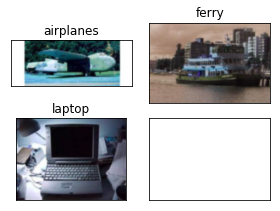

In [4]:
def plot_sample(img):
    """
    Plots image with axis turned off.
    """
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(img, interpolation='bicubic')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()


def show_examples(batch):
    """
    Plots one example for each category
    """
    def get_examples():
        d = dict()
        data = batch['data']
        labels = batch['labels']
        for img, label in zip(data, labels):
            if len(d) == n_classes:
                break
            d[label] = img
        return d
    
    examples = get_examples()
    half = n_classes // 2
    fig, ax = plt.subplots(half + 1, 2, figsize=(4, 3*half), subplot_kw={'xticks': [], 'yticks': []})
    for i in range(n_classes):
        ix = i // 2
        jx = i % 2
        ax[ix, jx].imshow(examples[i], interpolation='bicubic')
        ax[ix, jx].set_title(label_names[i])
    plt.tight_layout()


show_examples(train_batch)

In [5]:
def get_descriptors(img):
    """
    Returns SIFT descriptors for given image
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    _, des = sift.detectAndCompute(gray, None)
    return des


def get_all_descriptors(batch):
    """
    Returns
    1) dictionary with keys - image numbers and values - sets of SIFT descriptors
    2) list of all SIFT descriptors of all images)
    """
    img2desc = {}
    all_descriptors = []
    n_img = len(batch['data'])
    for i, img in enumerate(batch['data']):
        if (i + 1) % 1000 == 0:
            print('{:.0f}%'.format(i / n_img * 100))
        des = get_descriptors(img)
        if des is None:
            continue
        img2desc[i] = des
        if des.shape[0] >= 5:
            for descriptor in des:
                all_descriptors.append(descriptor)
    print('{0} out of {1} images have at least 5 descriptors'.format(len(img2desc), n_img))
    return img2desc, all_descriptors

In [6]:
%%time

img2desc, all_descriptors = get_all_descriptors(train_batch)
print('Total number of descriptors:', len(all_descriptors))

141 out of 141 images have at least 5 descriptors
Total number of descriptors: 53760
Wall time: 4.78 s


In [7]:
def run_k_means(data, k):
    """
    Creates MiniBatchKMeans object and clusters data in k groups
    """
    kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=k, n_init=20, init_size=3*n_clusters).fit(data)
    s = 'Clustering in {0} clusters took {1} iterations'
    s = s.format(k, kmeans.n_iter_, kmeans.inertia_)
    print(s)
    return kmeans


def get_histogram(descriptors, kmeans):
    """
    Builds histogram:
        for each descriptor in descriptors we find the closest center among kmeans clusters
        the set of centers is vocabulary
        for each center we count the number of descriptors for which this center was chosen
        these counts are the resulting histogram (aka bag-of-visual-words, aka bag-of-features)
    """
    k = kmeans.n_clusters
    hist = np.zeros(k)
    words = kmeans.predict(descriptors)
    for word in words:
        hist[word] += 1
    return hist

In [8]:
%%time

# Here we get all descriptors for training dataset and perform the clustering
print("I'm here")

n_clusters = 500
all_descriptors = np.array(all_descriptors)
kmeans = run_k_means(all_descriptors, n_clusters)

I'm here
Clustering in 500 clusters took 12 iterations
Wall time: 13.2 s


In [9]:
%%time

# Here we create histograms for each image (unsing precomputed desctiptors stored in img2desc)
print("I'm here")

n = len(img2desc)
y_train = np.zeros(n)
X_train = np.zeros((n, n_clusters))

i = 0
for img_ix, descriptors in img2desc.items():
    X_train[i,:] = get_histogram(descriptors, kmeans)
    y_train[i] = train_batch['labels'][img_ix]
    i += 1

print("Done")

I'm here
Done
Wall time: 1.05 s


In [10]:
%%time

# Here we train the SVM classifier (samples are histograms, labels are classes)
print("I'm here")

svm = sklearn.svm.SVC(gamma='scale')
svm.fit(X_train, y_train)

print("DONE")

I'm here
DONE
Wall time: 36 ms


In [11]:
cnt_bad = 0


def get_prediction(img, kmeans, svm):
    """
    Get prediction for given image
    """
    descriptors = get_descriptors(img)
    if descriptors is None:
        global cnt_bad
        cnt_bad += 1
        return randint(0, n_classes)
    hist = get_histogram(descriptors, kmeans)
    return svm.predict(hist.reshape(1, -1))


def get_all_predictions(batch, kmeans, svm):
    """
    Get prediction for all images in the batch and compute accuracy
    """
    cnt_ok = 0
    for img, true_label in zip(batch['data'], batch['labels']):
        pred_label = get_prediction(img, kmeans, svm)
        if pred_label == true_label:
            cnt_ok += 1
    n = len(batch['data'])
    print('No descriptors were detected for {} images'.format(cnt_bad))
    print('Accuracy: {:.2f}'.format(cnt_ok / n))

In [12]:
%%time
print("I'm here")

get_all_predictions(test_batch, kmeans, svm)
seed(42)

I'm here
No descriptors were detected for 0 images
Accuracy: 0.77
Wall time: 2.78 s


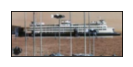

I guess this is
LAPTOP
Its real label is
FERRY


In [13]:
def classify_random(kmeans, svm, i=None):
    """
    Classifies random image from the test set
    """
    if i is None:
        i = randint(0, n_test-1)
    img = test_batch['data'][i]
    plot_sample(img)
    label_pred = int(get_prediction(img, kmeans, svm))
    print('I guess this is')
    print(label_names[label_pred].upper())
    print('Its real label is')
    label_true = test_batch['labels'][i]
    print(label_names[label_true].upper())


classify_random(kmeans, svm)